In [1]:
import ipyvuetify as v
import ipywidgets as widgets
import os
import ee
from scripts import gdrive
import subprocess
import glob
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#for testing 
year = '2019'
asset_name = "users/bornToBeAlive/Glad_Singapore_boundaries"

In [3]:
#initialize earth engine
ee.Initialize()

In [4]:
widget_alert = v.Alert(children=[''], type='info', text=True, class_="mt-5")
#widget_alert

Widget_result = v.Flex(xs12=True, lg6=True, children=['No results yet'])

In [5]:
#define the constants
START_SEPAL = "the process has been launch on your SEPAL account"
NO_INPUT = "No input have been selected, provide them through step 1."
NO_TASK = "The GEE process has not been completed, launch it or run a status check through step 2."
ALREADY_DONE = "This computation has already been performed\nYou can find your results in the glad_result folder of your computer"
BUTTON_COLOR = 'lightgreen'

In [6]:
#function 
def merge(filename, alert_map, glad_dir):
    """ merge into a single tif files"""
    
    #create command
    command = [
        'gdal_merge.py',
        '-o', alert_map,
        '-v', '-co', '"COMPRESS=LZW"'
    ]
    #add the input files
    for file in glob.glob(glad_dir + filename):
        command.append(file)

    process = subprocess.run(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True
    ) 
    
    return(process.stdout)
    
def clump(alert_map, clump_map):
    """ clump the results"""
    process = subprocess.run(
        [
            'oft-clump', 
            '-i', alert_map, 
            '-o', clump_map
        ],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True
    )
    
    return(process.stdout)
    
def calc(clump_map, alert_map, alert_stats):
    """Compute the statistics per each individual clump"""
    process = subprocess.run(
        [
            'oft-his', 
            '-um', clump_map, 
            '-i', alert_map, 
            '-o', alert_stats,
            '-maxval','3'
        
        ],
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        universal_newlines=True
    )
    
    return(process.stdout)  
    
def create_result_folder():
    """Create a folder to download the glad images"""
    glad_dir = os.path.join(os.path.expanduser('~'), 'glad_results')+'/'
    if not os.path.exists(glad_dir):
        os.makedirs(glad_dir)
    
    return glad_dir

def download_task_tif(filename, glad_dir):
    drive_handler = gdrive.gdrive()
    files = drive_handler.get_files(filename)
    drive_handler.download_files(files, glad_dir)
    
def delete_merged_file(pathname):
    #list the input files
    file_list = []
    for file in glob.glob(pathname):
        file_list.append(file)
        
    count = 0
    for file in file_list:
        os.remove(file)
        count += 1
    return "{0} files dleted".format(count)
        
def construct_filename(asset_name, year):
    """return the filename associated with the current task"""
    aoi_name= os.path.split(asset_name)[1]
    filename = 'alerts_' + aoi_name + '_' + str(year) + "test0-0" #remove test when it will be in production 
    
    return filename

In [7]:
def check_for_inputs():
    """check if the inputs exist and have a value"""
    
    #I just need to check for existance as the first cell has a default value
    return ('country_code' in globals() and 'year' in globals())

def check_task_status(asset_name, year):
    #search for the task in task_list
    filename = construct_filename(asset_name, year)
    tasks_list = ee.batch.Task.list()
    current_task = ''
    for task in tasks_list:
        if task.config['description'] == filename:
            current_task = task
            break
            
    #task not launched 
    if current_task == '':
        return False
    
    if current_task.state == "RUNNING":
        return False
    
    return True

def check_for_stats(filename):
    return glob.glob(filename)

def display_graph(filename, aoi_name, year):
    
    #inizialize the plot
    fig_hist = plt.figure(1)
    
    print(filename)
    data = np.loadtxt(filename, delimiter=' ')
    
    bins = 30

    #need to confirm who's who
    Y_5 = data[:,5]
    Y_5 = np.ma.masked_equal(Y_5,0).compressed()
    maxY5 = np.amax(Y_5)

    #null if all the alerts have been confirmed
    Y_4 = data[:,4]
    Y_4 = np.ma.masked_equal(Y_4,0).compressed()
    try:
        maxY4 = np.amax(Y_4)
        data_hist = [Y_5, Y_4]
        colors = ["#C26449", "#59C266"]
        labels = ['confirmed alert', 'likeky alert']
    except ValueError:  #raised if `Y_4` is empty.
        maxY4 = 0
        data_hist = [Y_5]
        colors = ["#C26449"]
        labels = ['confirmed alert']
        pass
    
    
     
    
    #plot in kilometers ?

    plt.hist(
        data_hist, 
        label=labels, 
        weights=data_hist,color=colors, 
        bins=bins, 
        density=True, 
        histtype='bar', 
        stacked=True
    )
    plt.xlim(0, max(maxY5, maxY4))
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.title('Distribution of GLAD alerts for '+ aoi_name + " in " + year)
    plt.xlabel('patch size (px)')
    plt.ylabel('number of pixels (log)')
    
    return fig_hist

In [8]:
import time

def run_GEE_process(asset_name, year):
    
    

    global START_SEPAL 
    global NO_INPUT
    global NO_TASK
    global ALREADY_DONE
    
    global widget_alert
    global widget_result

    if not asset_name or not year:
        return 'error', NO_INPUT
    
    aoi_name= os.path.split(asset_name)[1]
        
    #define the files variables
    glad_dir = create_result_folder()
    
    #year and country_code are defined by step 1 cell
    alert_map   = glad_dir + "glad_" +year + "_" + aoi_name + ".tif"
    clump_map   = glad_dir + "tmp_clump_" + year + "_" + aoi_name + ".tif"
    alert_stats = glad_dir + "stats_glad_" + year + "_" + aoi_name + ".txt"
        
    #check that the Gee process is finished
    if not check_task_status(asset_name, year):
        return 'error', NO_TASK
        
    #check that the process is not already done
    #print(START_SEPAL)
    if check_for_stats(alert_stats):
        widget_alert.children = [ALREADY_DONE]
    else:        
        #start the postprocessing
    
        #download from GEE
        filename = construct_filename(asset_name, year)
        download_task_tif(filename, glad_dir)
        
        #process data with otf
        filename = construct_filename(asset_name, year) + "*.tif"
        io = merge(filename, alert_map, glad_dir)
        widget_alert.children = [io]
        #print(io)
        
        time.sleep(5)
            
        io = delete_merged_file(glad_dir + filename)
        widget_alert.children = [io]
        #print(io)
        
        time.sleep(5)
            
        io = clump(alert_map, clump_map)
        widget_alert.children = [io]
        #print(io)
        
        time.sleep(5)
            
        io = calc(clump_map, alert_map, alert_stats)
        widget_alert.children = [io]
        #print(io)
        
        time.sleep(5)
    
    widget_alert.children = ['displaying the graph']
    widget_result.children = [display_graph(alert_stats, aoi_name, year)]
        
    return 'success', 'Computation complete'

In [9]:
#validate the selected data

sepal_process_btn = v.Btn(
    color='primary', 
    children=[
        v.Icon(left=True, children=['mdi-cogs']),
        'Run SEPAL process'
    ]
)
widget_validate_data = v.Container(children=[sepal_process_btn])

def toggleLoading(btn):
    btn.loading = not btn.loading
    btn.disabled = btn.loading

def on_click(widget, event, data):
    
    global widget_alert
    
    #do something 
    toggleLoading(sepal_process_btn)
    alert_type, message = run_GEE_process(asset_name, year)
    toggleLoading(sepal_process_btn)
    
    widget_alert.type = alert_type
    widget_alert.children = [message]
    

widget_validate_data.on_event('click', on_click)
#widget_validate_data

In [10]:
#create the display 
inputs = v.Layout(
    _metadata={'mount-id': 'data-input'},
    row=True,
    class_="pa-5",
    align_center=True, 
    children=[
        v.Flex(xs12=True, children=[widget_validate_data]),
        v.Flex(xs12=True, children=[widget_alert])
    ]
)
#inputs

SEPAL_content_main =  v.Layout(
    _metadata={'mount_id': 'content-main'},
    row=True,
    xs12=True,
    align_center=True, 
    class_="ma-5",
    children=[
        v.Card( 
            class_="ma-5 pa-5",
            raised=True,
            xs12=True,
            md5=True,
            children=[
                v.Html(xs12=True, tag='h2', children=['Run the SEPAL process']),
                v.Flex(xs12=True, lg6=True, children=[inputs]),   
            ]
        ),
        v.Card( 
            class_="ma-5 pa-5",
            raised=True,
            xs12=True,
            md5=True,
            children=[
                v.Html(xs12=True, tag='h2', children=['data Result']),
                Widget_result  
            ]
        )
    ]
)
SEPAL_content_main

Layout(align_center=True, children=[Card(children=[Html(children=['Run the SEPAL process'], tag='h2'), Flex(ch…

/home/prambaud/glad_results/stats_glad_2019_Glad_Singapore_boundaries.txt


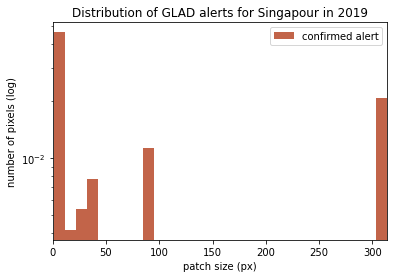

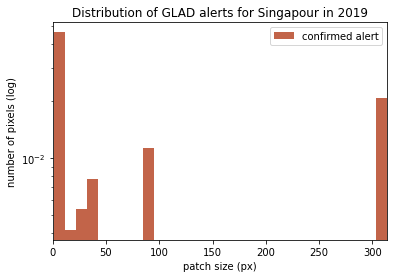

In [11]:
#pathname = "/home/prambaud/glad_results/stats_glad_2019_Glad_Singapore_boundaries.txt"
#year = '2019'
#aoi_name = 'Singapour'
#display_graph(pathname, aoi_name, year)